<a href="https://colab.research.google.com/github/Konerusudhir/machine_learning_exercises/blob/master/SemanticSearch0_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MP NFTs Semantic Search using Text and Images**

I fetch MakersPlace NFTs(10K) and Index them using Faiss. Search is performed using Query embedding on the Text index or Image embedding on Image index. Below are the individual steps.

1.   Fetch Makers Place Contract NFT Token ids(n ...m) meta data using Alchemy 
     API. Extract previwe image URLs from the response
2.   Fetch Title text for each NFT. Parallell execution is used.
3.   Download Clip Model(openai/clip-vit-large-patch14) from HuggingFace and instantiate TextModel and VIsion Model.
4.   Create Title Text Index using Faiss
5.   Generate text embeddings for Titles using Clip Text Model and add them to text index index
6.   Load pre generated Image index
7.   Build Gradio App for searching NFTs
8.   Load Web App using Public URL and have fun

## Acknowledgements
1. Text index is built using NFT Titles only. Limited text to alpha numeric characters only. 
2. This is setup is not evaluated using curated/benchmark dataset to verify
   accuracy
3. Index generation and Index search is not on GPU. Only Image embedding generation is in GPU
4. GPU Memory clean up is done manually. Need fine tuning to avoid OOM errors
5. Search results in unintended images like NSFW images




In [1]:
%%capture
!pip install gradio
!pip install transformers
!pip install faiss-gpu
!pip install torch
!pip install Pillow
!pip install matplotlib
!pip install nltk
!pip install spacy

In [2]:
import os
import shutil
import math 
import glob
import json
import pickle
import requests
import time
import re
import string
from io import BytesIO

import nltk
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import spacy
import torch

from concurrent.futures import ThreadPoolExecutor
import numpy as np
from numpy import random
from PIL import Image
# from IPython import display
import matplotlib.pyplot as plt

import faiss

if 'workspace/semantic_search' in os.getcwd():
    IS_HF_SPACE = False
else:
    IS_HF_SPACE = True

if IS_HF_SPACE:
    ROOT_FOLDER = './'
else:
    ROOT_FOLDER = os.path.join("hf", "mp_art_search_1_1")

DIMENSIONS = 768
GATEWAY_URL = "https://eth-mainnet.g.alchemy.com/nft/v2/rBshNbJGutTbf2ACdQ9XyGhhc1uSolds/getNFTMetadataBatch"
IPFS_GATEWAY = 'https://ipfsgateway.makersplace.com/ipfs/'
MP_CONTRACT_ADDRESS = "0x2963ba471e265e5f51cafafca78310fe87f8e6d1"
SUPPORTED_CONTENT_TYPES = ['image/jpeg','image/png','image/gif']
IPFS_IMAGE_IDS_FILE_NAME = "ipfs_image_ids.pickle"
INDEX_FOLDER = os.path.join(ROOT_FOLDER, "indexes")
IMAGES_FOLDER = os.path.join(ROOT_FOLDER, "images")
EXAMPLES_FOLDER = os.path.join(ROOT_FOLDER, "examples")
IPFS_IMAGE_IDS_PATH = os.path.join(INDEX_FOLDER, IPFS_IMAGE_IDS_FILE_NAME)
MIN_TOKEN_ID = 1
MAX_TOKEN_ID = 20000
GATEWAY_QUERY_BATCH_SIZE = 100
VISION_MODEL_INPUT_BATCH_SIZE = 4
TEXT_MODEL_INPUT_BATCH_SIZE = 10
SEARCH_RESULTS_DISPLAY_COUNT = 4
LOG_DISPLAY_THRESHOLD = 1000
RANDOM_SEED = 7
np.random.seed(RANDOM_SEED)

# Load stop words
nltk.download('stopwords')

# Load spacy
# nlp = spacy.load('en_core_web_sm')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/skoneru/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# def clean_directories():
#   shutil.rmtree(IMAGES_FOLDER, ignore_errors=True)
#   shutil.rmtree(INDEX_FOLDER, ignore_errors=True)

def create_directories():
  if not os.path.exists(EXAMPLES_FOLDER):
    os.mkdir(EXAMPLES_FOLDER) 
  if not os.path.exists(INDEX_FOLDER):
    os.mkdir(INDEX_FOLDER)


# clean_directories()
create_directories()

# Fetch NFTs metadata

In [4]:
class FetchClass:
    def __init__(self):
        self.image_duplicates_count = 0
        self.nft_data = np.empty((0,3), str)
        self.ipfs_image_ids = set()

    def fetch_image_urls(self, min_token_id):
        max_toke_id = min_token_id + GATEWAY_QUERY_BATCH_SIZE
        token_id_requests = [] 
        for i in range(min_token_id, max_toke_id):
            token_id_requests.append(
                {
                    "contractAddress": MP_CONTRACT_ADDRESS,
                    "tokenId": f"{i}",
                    "tokenType": "ERC721"
                }
            )

        payload = {
            "tokens": token_id_requests,
            "refreshCache": False
        }
        headers = {
            "accept": "application/json",
            "content-type": "application/json"
        }

        try:
            responses = requests.post(GATEWAY_URL, json=payload, headers=headers)
            nfts_metadata = json.loads(responses.text)

            for nft_metadata in nfts_metadata:
                imageUrl = nft_metadata['metadata'].get('imageUrl', None)
                description = nft_metadata.get('title', None)
                tokenId = nft_metadata['id'].get('tokenId', None)
                if imageUrl is not None and description is not None:
                    ipfs_id = imageUrl.split('/')[-1]
                    if ipfs_id not in self.ipfs_image_ids:
                        self.ipfs_image_ids.add(ipfs_id)
                        self.nft_data = np.append(
                            self.nft_data, 
                            np.array([[ipfs_id,description,tokenId]]), axis=0)
                    else:
                        self.image_duplicates_count += 1
                        if self.image_duplicates_count%LOG_DISPLAY_THRESHOLD == 0:
                            print(f"Found {self.image_duplicates_count} duplicates")
        except Exception as e:
            print(f"Exception calling Alchemy API {e}")
        
np_file_prefix = "mp_nft_data_np_array_12k.pickle"
np_file_name = f"{np_file_prefix}.npy"
np_file_path = os.path.join(INDEX_FOLDER, np_file_name)
print(np_file_path)
if os.path.exists(np_file_path):
    nft_data = np.load(np_file_path)
else:
    fetch_class = FetchClass()
    for batch_start_index in range(
        MIN_TOKEN_ID, MAX_TOKEN_ID, GATEWAY_QUERY_BATCH_SIZE):
        
        fetch_class.fetch_image_urls(batch_start_index)
        
        if (batch_start_index - 1)%LOG_DISPLAY_THRESHOLD == 0:
            print(f"Fetched batch from {batch_start_index}")
        
        time.sleep(0.2)    

    nft_data = fetch_class.nft_data
    np.save(np_file_path, nft_data)

print(f"""
    NFT Data Array shape: {nft_data.shape}
    """)

hf/mp_art_search_1_1/indexes/mp_nft_data_np_array_12k.pickle.npy

    NFT Data Array shape: (12306, 3)
    


# Download all NFTs images

In [5]:
img_local_paths = []
from concurrent.futures import ThreadPoolExecutor
def fetch_image(ipfs_image_id):

  image_url = os.path.join(IPFS_GATEWAY,ipfs_image_id) 
  # file_name = f"{image_url.split('/')[-1]}_{time.time_ns()}.jpeg"
  file_name = image_url.split('/')[-1]
 
  image_local_path = os.path.join(IMAGES_FOLDER,file_name)
  # print(f"{image_url} -- {file_name} -- {image_local_path}")
  
  if not os.path.exists(image_local_path):    
    response = requests.get(image_url)
    content_type = response.headers.get('content-type')
    # print(f"content type: {content_type}")
    if response.status_code and content_type in SUPPORTED_CONTENT_TYPES:
        img = Image.open(BytesIO(response.content))
        img.thumbnail((224, 224))
        # print(img)
        # img.save(image_local_path,'png')
        img_byte_arr = BytesIO()
        img.save(img_byte_arr, format='png')
        img_byte_arr = img_byte_arr.getvalue()
        
        fp = open(image_local_path, 'wb')
        fp.write(img_byte_arr)
        fp.close()
        # return img
    else:
        print(f"HTTP Code:{response.status_code} - {content_type} - IPFS ID:{ipfs_image_id}")
        # return None
    
  img_local_paths.append(image_local_path)  
  # display.Image(image_local_path)    

  # return img_local_path
ipfs_image_ids = nft_data[:,0]
if not IS_HF_SPACE:
    # fetch_image(image_urls[2])
    with ThreadPoolExecutor(max_workers=32) as executor:
        executor.map(fetch_image, ipfs_image_ids)

    downloaded_images_count = len(img_local_paths)
    print(f"Downloaded {downloaded_images_count} Images")

Downloaded 12302 Images


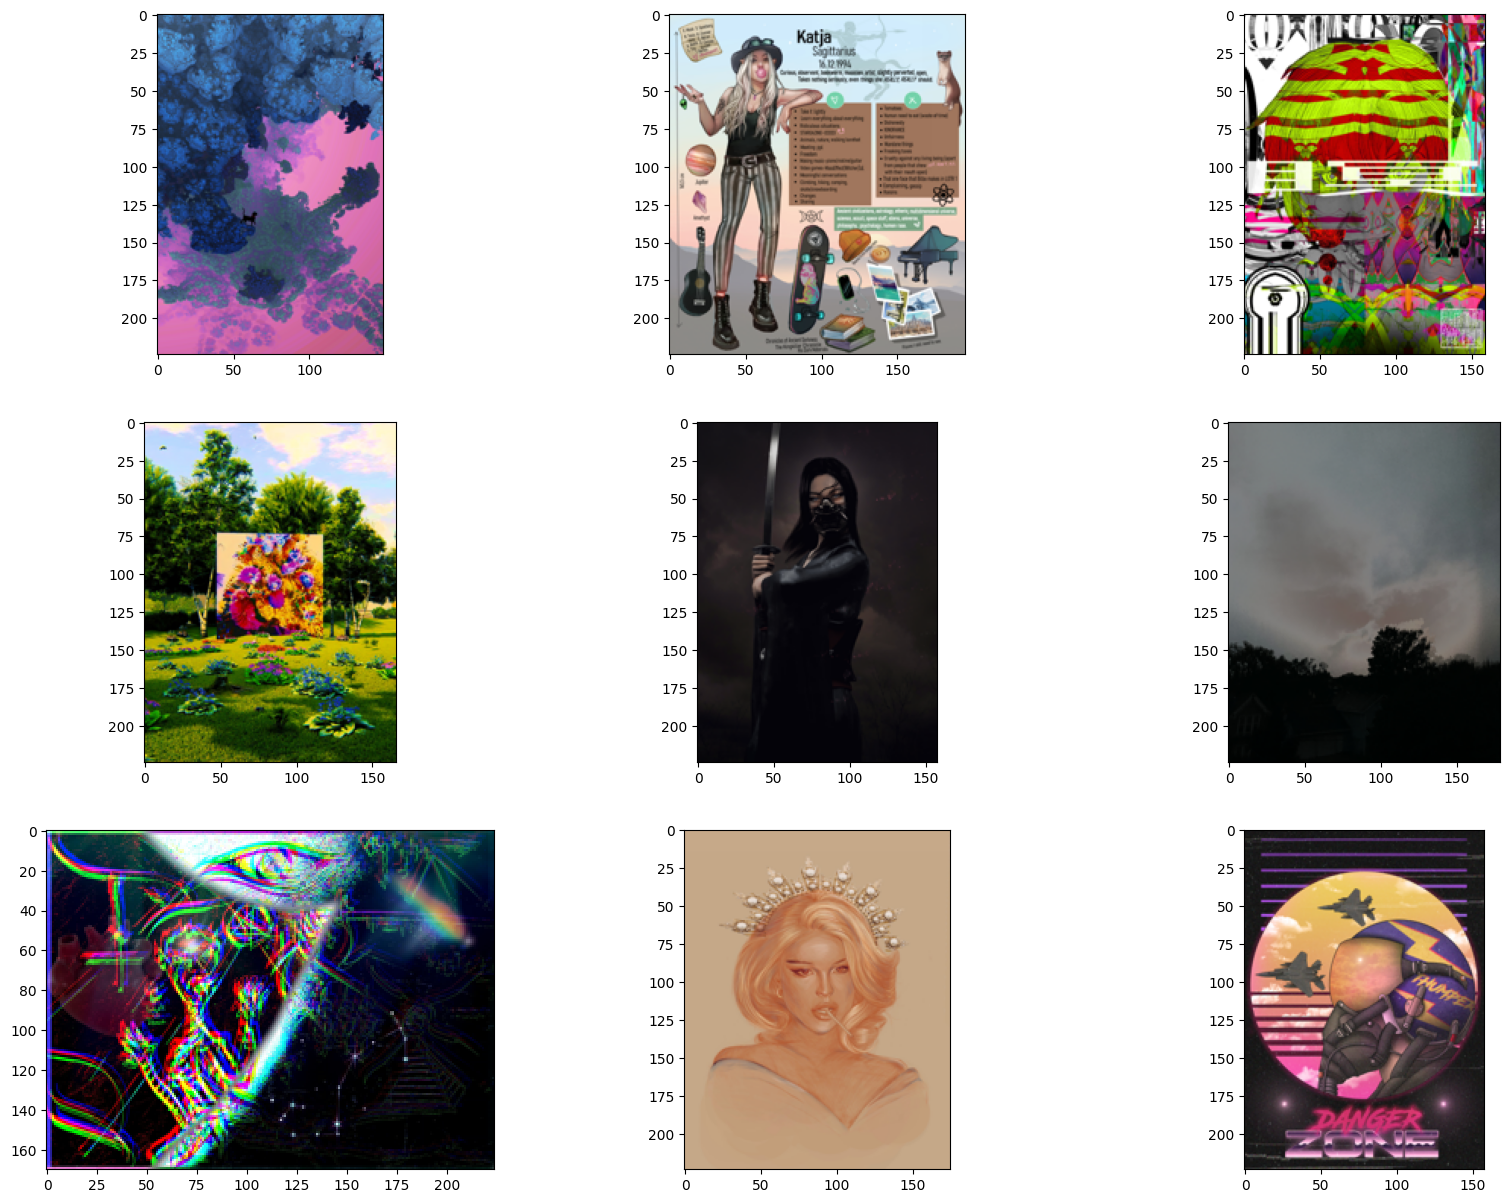

In [6]:
def fetch_image_object(ipfs_image_id):

    image_url = os.path.join(IPFS_GATEWAY,ipfs_image_id) 
    response = requests.get(image_url)
    content_type = response.headers.get('content-type')
    # print(f"content type: {content_type}")
    if response.status_code and content_type in SUPPORTED_CONTENT_TYPES:
        img = Image.open(BytesIO(response.content))
        img.thumbnail((224, 224))
        # print(img)
        return img
    else:
        print(f"HTTP Code:{response.status_code} - {content_type} - IPFS ID:{ipfs_image_id}")
        return None

if not IS_HF_SPACE:
    rows=3
    cols=3
    img_count = 0

    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20,15))
    random_image_ids = random.randint(len(ipfs_image_ids), size=(rows*cols))
    # print(random_image_ids)
    random_image_ipfs_ids = [ipfs_image_ids[random_image_ids[i]] for i in range(len(random_image_ids))]
    # print(random_image_ipfs_ids)
    with ThreadPoolExecutor(max_workers=32) as executor:
        downloaded_images=list(executor.map(fetch_image_object, random_image_ipfs_ids))

    for i in range(rows):
        for j in range(cols):        
            if img_count < len(random_image_ipfs_ids):
                img = fetch_image_object(random_image_ipfs_ids[img_count])
                img_array = np.asarray(downloaded_images[img_count])
                axes[i, j].imshow(img_array)
                img_count+=1

# Clean NFT title Text

In [7]:
def clean_string(text, stem="None"):

    final_string = ""

    text = re.sub(r"[^a-zA-Z0-9 ]", "", text)

    # Make lower
    text = text.lower()

    # Remove line breaks
    text = re.sub(r'\n', '', text)

    # Remove puncuation
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)

    # Remove stop words
    text = text.split()
    useless_words = nltk.corpus.stopwords.words("english")
    useless_words = useless_words + ['hi', 'im']

    text_filtered = [word for word in text if not word in useless_words]

    # Remove numbers
    # text_filtered = [re.sub(r'\w*\d\w*', '', w) for w in text_filtered]

    # Stem or Lemmatize
    if stem == 'Stem':
        stemmer = PorterStemmer() 
        text_stemmed = [stemmer.stem(y) for y in text_filtered]
    elif stem == 'Lem':
        lem = WordNetLemmatizer()
        text_stemmed = [lem.lemmatize(y) for y in text_filtered]
    elif stem == 'Spacy':
        text_filtered = nlp(' '.join(text_filtered))
        text_stemmed = [y.lemma_ for y in text_filtered]
    else:
        text_stemmed = text_filtered
    
    partial_string = text_stemmed[0:60]
    final_string = ' '.join(partial_string)

    return final_string



# 3 - Download Clip Model

In [8]:
from transformers import CLIPModel, CLIPProcessor, CLIPTokenizer, CLIPTextModelWithProjection, CLIPVisionModelWithProjection, CLIPImageProcessor, CLIPTextModel,  CLIPVisionModel, TFCLIPTextModel, TFCLIPVisionModel


clip_model_id = "openai/clip-vit-large-patch14"

clip_model = CLIPModel.from_pretrained(clip_model_id)
clip_processor = CLIPProcessor.from_pretrained(clip_model_id)

text_model = CLIPTextModel.from_pretrained(clip_model_id)
text_projection_model = CLIPTextModelWithProjection.from_pretrained(clip_model_id)
tokenizer = CLIPTokenizer.from_pretrained(clip_model_id)

vision_model = CLIPVisionModel.from_pretrained(clip_model_id)
vision_projection_model = CLIPVisionModelWithProjection.from_pretrained(clip_model_id)
image_processor = CLIPImageProcessor.from_pretrained(clip_model_id)

# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
if torch.backends.mps.is_available():
    device = torch.device("mps")
    x = torch.ones(1, device=device)
    print(x)
else:
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

clip_model.to(device)

Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.16.layer_norm1.weight', 'vision_model.encoder.layers.3.mlp.fc1.bias', 'vision_model.encoder.layers.7.layer_norm1.weight', 'vision_model.encoder.layers.12.mlp.fc1.weight', 'vision_model.encoder.layers.14.self_attn.out_proj.weight', 'vision_model.encoder.layers.12.self_attn.q_proj.weight', 'vision_model.encoder.layers.10.self_attn.q_proj.bias', 'vision_model.encoder.layers.2.self_attn.v_proj.bias', 'vision_model.encoder.layers.2.self_attn.k_proj.bias', 'vision_model.encoder.layers.18.self_attn.k_proj.bias', 'vision_model.encoder.layers.1.self_attn.v_proj.weight', 'vision_model.encoder.layers.21.self_attn.out_proj.bias', 'vision_model.encoder.layers.21.mlp.fc1.bias', 'vision_model.encoder.layers.0.self_attn.q_proj.bias', 'vision_model.encoder.layers.2.layer_norm1.weight', 'vision_model.encoder.layers.3.self_attn.out_proj.weight', 'vision_model.

tensor([1.], device='mps:0')


CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 768)
      (position_embedding): Embedding(77, 768)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0): CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-05, element

In [9]:
def get_text_embeds(queries):
    inputs = tokenizer(queries, padding=True, return_tensors="pt")
    outputs = text_model(**inputs)
    return outputs.pooler_output.detach().numpy()

def get_image_embeds(images):
  inputs = image_processor(images=images, return_tensors="pt")
  outputs = vision_model(**inputs)
  return outputs.pooler_output.detach().numpy()

def get_clip_embeds(
    text = [''],
    images = np.zeros(shape=[224,224,3], dtype=float)):
    inputs = clip_processor(
        text=text, 
        images=images, 
        return_tensors="pt", 
        padding=True)
    inputs.to(device)
    outputs = clip_model(**inputs)
    
    return (
        outputs.text_embeds.to(torch.device("cpu")).detach().numpy(), 
        outputs.image_embeds.to(torch.device("cpu")).detach().numpy())

def get_text_projection_embeds(queries):
    inputs = tokenizer(queries, padding=True, return_tensors="pt")
    outputs = text_projection_model(**inputs)
    return outputs.text_embeds.detach().numpy()


def get_image_projection_embeds(images):
  inputs = image_processor(images=images, return_tensors="pt")
  outputs = vision_projection_model(**inputs)
  return outputs.image_embeds.detach().numpy()


text = ['photo of a cat']
images = [fetch_image_object(ipfs_image_ids[0])]
text_model_embeds = get_text_embeds(text)
print(text_model_embeds.shape)
vision_model_embeds = get_image_embeds(images)
print(vision_model_embeds.shape)

clip_text_embeds, clip_image_embeds = get_clip_embeds(text, images)
print(f"{clip_text_embeds.shape}, {clip_image_embeds.shape}")

print(f"Text embeds equal {np.array_equal(text_model_embeds, clip_text_embeds)}")
print(f"Vision embeds equal {np.array_equal(vision_model_embeds, clip_image_embeds)}")
# print(text_model_embeds)
# print(clip_text_embeds)


clip_text_embeds_empty_image, clip_image_embeds_empty_image = get_clip_embeds(text=text)
# print(f"{clip_text_embeds_empty_image.shape}, {clip_image_embeds_empty_image.shape}")
print(f"Text embeds with empty image equal {np.array_equal(clip_text_embeds_empty_image, clip_text_embeds)}")


clip_text_embeds_empty_text, clip_image_embeds_empty_text = get_clip_embeds(images=images)
# print(f"{clip_text_embeds_empty_text.shape}, {clip_image_embeds_empty_text.shape}")
print(f"Image embeds with empty image equal {np.array_equal(clip_image_embeds_empty_text, clip_image_embeds)}")

text_projection_embeds = get_text_projection_embeds(text)
# print(f"Text projection embeds shape: {text_projection_embeds.shape}")
print(f"Text embeds Projected & Normal {np.array_equal(text_projection_embeds, text_model_embeds)}")

image_projection_embeds = get_image_projection_embeds(images)
# print(f"Image projection embeds shape: {image_projection_embeds.shape}")
print(f"Image embeds Projected & Normal {np.array_equal(image_projection_embeds, vision_model_embeds)}")

print(f"Text embeds Projected & Combined {np.array_equal(text_projection_embeds, clip_text_embeds)}")
print(f"Image embeds Projected & Combined {np.array_equal(image_projection_embeds, clip_image_embeds)}")

# print(text_projection_embeds)
# print(clip_text_embeds)

(1, 768)
(1, 1024)
(1, 768), (1, 768)
Text embeds equal False
Vision embeds equal False
Text embeds with empty image equal True
Image embeds with empty image equal True
Text embeds Projected & Normal False
Image embeds Projected & Normal False
Text embeds Projected & Combined False
Image embeds Projected & Combined False


In [10]:
TEXT_MODEL_INPUT_BATCH_SIZE = 450
storage = "Flat"
index_name = f"IDMap,{storage}"

text_index = faiss.index_factory(DIMENSIONS, f"{index_name}")
image_index = faiss.index_factory(DIMENSIONS, f"{index_name}")
combined_Index = faiss.index_factory(DIMENSIONS, f"{index_name}")

content_ids_map = {}

banned_token_ids = {
    1185 # hash special charaters which is crashing Tokenizer
}




def build_index():
    nfts_count = 0
    text_batch = []
    ipfs_ids = []
    embeds_count = 0
    batches = np.array_split(nft_data, TEXT_MODEL_INPUT_BATCH_SIZE)
    
    for nft_data_batch in batches:    
        cleaned_text = []
        images = []
        ipfs_ids_hashes = []
        title_text_batch = nft_data_batch[:,1].tolist()
        batch_length = len(title_text_batch)

        try:
            # print(f"Batch length: {batch_length}")
            for i in range(batch_length):
                token_id = int(nft_data_batch[i][2])
                if token_id not in banned_token_ids:
                    ipfs_id = nft_data_batch[i][0]
                    ipfs_id_hash = hash(ipfs_id)
                    ipfs_ids_hashes.append(ipfs_id_hash)
                    content_ids_map[ipfs_id_hash] = ipfs_id
                    cleaned_string = clean_string(title_text_batch[i])
                    
                    cleaned_text.append(cleaned_string)
                    image_local_path = os.path.join(IMAGES_FOLDER,nft_data_batch[i][0])
                    images.append(get_reshaped_image(image_local_path))

            if len(cleaned_text) > 0:
                text_embeds, image_embeds = get_clip_embeds(text=cleaned_text, images=images)
                text_index.add_with_ids(text_embeds, np.array(ipfs_ids_hashes))
                image_index.add_with_ids(image_embeds, np.array(ipfs_ids_hashes))
               
        except Exception as e:        
            print(f"""
            Text : {nft_data_batch}  - cleaned: {cleaned_text}
            IPFS Hashes: {ipfs_id_hash} 
            exception: {e}
            """)
        embeds_count+=batch_length      
        print(f"Created embeds for {embeds_count} descriptions")
        # nfts_count+=len(nft_data_batch)
        # print(f"Completed indexing {nfts_count} NFTs")


index_file_prefix = index_name.replace(',', '_')
text_index_file_name = f"{index_file_prefix}_text.index"
image_index_file_name = f"{index_file_prefix}_image.index"

text_index_file_path = os.path.join(INDEX_FOLDER, text_index_file_name)
image_index_file_path = os.path.join(INDEX_FOLDER, image_index_file_name)

if os.path.exists(text_index_file_path):
    text_index = faiss.read_index(text_index_file_path)
    image_index = faiss.read_index(image_index_file_path)
else:    
    build_index()
    faiss.write_index(text_index, text_index_file_path)
    faiss.write_index(image_index, image_index_file_path)

# build_index()
# faiss.write_index(text_index, text_index_file_path)
# faiss.write_index(image_index, image_index_file_path)


id_map_file_name = f"{index_file_prefix}_ids.pickle"
id_map_path = os.path.join(INDEX_FOLDER, id_map_file_name)
if os.path.exists(id_map_path):
    with open(id_map_path, 'rb') as f:
        content_ids_map = pickle.load(f)
else:
    with open(id_map_path, 'wb') as f:
        pickle.dump(content_ids_map, f)

# with open(id_map_path, 'wb') as f:
#     pickle.dump(content_ids_map, f)

print(f"Text Index Size: {text_index.ntotal}")
print(f"Image Index Size: {image_index.ntotal}")
print(f"Ids Size: {len(content_ids_map)}")

Text Index Size: 12251
Image Index Size: 12251
Ids Size: 12281


# Utils

In [11]:
def download_images_parallely(ipfs_ids):
    with ThreadPoolExecutor(max_workers=18) as executor:
        downloaded_images = list(executor.map(fetch_image_object, ipfs_ids))
    return downloaded_images

def search_using_text(text_q_index, text_strings):
    text_embeds,_ = get_clip_embeds(text=text_strings)  
    # print(f"Text EMbeds : {text_embeds}")    
    distances, id_hashes = text_q_index.search(text_embeds, SEARCH_RESULTS_DISPLAY_COUNT) 
    # print(id_hashes) 
    return (distances.flatten(),id_hashes.flatten())

def search_using_images(image_q_index, search_images):
    # reshaped_images = get_reshaped_image(search_images)
    _, image_embeds = get_clip_embeds(images=search_images)    
    # print(f"Image_embeds : {image_embeds}")   
    distances, id_hashes = image_q_index.search(image_embeds, SEARCH_RESULTS_DISPLAY_COUNT)
    return (distances.flatten(),id_hashes.flatten())

def read_ipfs_image_ids(image_ids_path):
    if os.path.exists(image_ids_path):
        with open(image_ids_path, 'rb') as f:
            return pickle.load(f)
    else:
        return set()

# Gradio Image search App

In [13]:
import gradio as gr

print(f"Text Index size: {text_index.ntotal}")
print(f"Image Index size: {image_index.ntotal}")
print(f"Ids size: {len(content_ids_map)}")

def search_images_by_image(query_image):
    return search_images('', query_image)

def search_images_by_text(query_text):
    return search_images(query_text, None)

def search_images(query_text, query_image):
    images_to_download = []
    # print(f"Received {query_text}:{query_image}")
    if len(query_text) > 0:
        text_distances, text_search_results = search_using_text(text_index, [query_text])
        for image_hash in text_search_results:
            images_to_download.append(content_ids_map[image_hash])
        img_distances, img_search_results = search_using_text(image_index, [query_text])
        for image_hash in img_search_results:
            images_to_download.append(content_ids_map[image_hash])     
        
    elif query_image is not None:
        # distances, search_results = search_using_images(image_index, [query_image])
        # # print(f"Search results: {search_results}")
        # for image_hash in search_results:
        #     images_to_download.append(content_ids_map[image_hash])        
        text_distances, text_search_results = search_using_images(text_index, [query_image])
        for image_hash in text_search_results:
            images_to_download.append(content_ids_map[image_hash])
        img_distances, img_search_results = search_using_images(image_index, [query_image])
        for image_hash in img_search_results:
            images_to_download.append(content_ids_map[image_hash])  
        
    # print(f"{text_search_results} \n. {img_search_results}")
    # text_distances.extend(img_distances)
    distances = list(text_distances) + list( img_distances)
    # text_search_results.extend(img_search_results)
    search_results = list(text_search_results) + list(img_search_results)      

    # print(f"Images to Download: {images_to_download}")        
    download_images = download_images_parallely(images_to_download)
    # print(f"search_results: {search_results}")
    # print(f"Images to download: {images_to_download}")
    image_objects = []
    for i in range(len(search_results)):
        image_id = content_ids_map.get(search_results[i], None)
        if image_id is not None:
            # local_path = os.path.join(IMAGES_FOLDER, image_id)
            image_objects.append(download_images[i])
        else:
            image_objects.append('https://ipfsgateway.makersplace.com/ipfs/QmNLgZQihgo1BpngQ9F6Tn89n4QC6nrnYAkv9fFza6C1wT')
    
    for i in range(len(distances)):
        distance_rounded = round(float(distances[i]),2)
        link_html = f"<u><a href='{os.path.join(IPFS_GATEWAY,content_ids_map[search_results[i]]) }' target='_blank' rel='noopener noreferrer'>Link</a></u> "
        diatance_html = f"Distance: {distance_rounded}"

        image_objects.append(f"{diatance_html} - {link_html}")
    # image_objects.append(query_text, query_image)
    
    return image_objects

example_images = [f"{EXAMPLES_FOLDER}/e{n}.jpeg" for n in range(4)]
example_text = ["surrealism art","3d art", "psychedelic art","Glitch Art"] #,"Photo of a Unicorn"
examples_queries = [example_images, example_text]
# print(examples_queries)
outputs = []
with gr.Blocks() as demo:
    gr.Markdown(value = '# Makers Place NFTs search')
    with gr.Row():
        with gr.Column(scale=0.5):            
            query_text = gr.Textbox(label="Text", value="")
            query_image = gr.Image(label="Image")
            search_btn = gr.Button("Search")
            examples_text_display=gr.Examples(
                examples=example_text, 
                inputs=query_text
                )
            examples_image_display=gr.Examples(
                examples=example_images, 
                inputs=query_image
                )            
        with gr.Column(scale=10):       
            with gr.Row():
                gr.HTML(value="<font size='+3'>Image Index Results</font>")
            with gr.Row():
                with gr.Column(min_width=224):   
                    img_result_0_image = gr.Image(label="img_result_0_image") # type="pil",
                    img_result_0_label = gr.HTML(value = '-')
                    img_result_0_btn = gr.Button("Related Images")
                with gr.Column(min_width=224):  
                    img_result_1_image = gr.Image(label="img_result_1_image")
                    img_result_1_label = gr.HTML(value = '-')
                    img_result_1_btn = gr.Button("Related Images")  
                with gr.Column(min_width=224):  
                    img_result_2_image = gr.Image(label="img_result_2_image")
                    img_result_2_label = gr.HTML(value = '-')
                    img_result_2_btn = gr.Button("Related Images")
                with gr.Column(min_width=224):  
                    img_result_3_image = gr.Image(label="img_result_3_image")
                    img_result_3_label = gr.HTML(value = '-')
                    img_result_3_btn = gr.Button("Related Images")
            with gr.Row():
                gr.HTML(value="<br><br> <font size='+3'>Text Index Results</font>")
            with gr.Row():
                with gr.Column(min_width=224):
                    result_0_image = gr.Image(label="result_0_image") # type="pil",
                    result_0_label = gr.HTML(value = '-')
                    result_0_btn = gr.Button("Related Images")    
                with gr.Column(min_width=224):
                    result_1_image = gr.Image(label="result_1_image")
                    result_1_label = gr.HTML(value = '-')
                    result_1_btn = gr.Button("Related Images")  
                with gr.Column(min_width=224):
                    result_2_image = gr.Image(label="result_2_image")
                    result_2_label = gr.HTML(value = '-')
                    result_2_btn = gr.Button("Related Images")
                with gr.Column(min_width=224):
                    result_3_image = gr.Image(label="result_3_image")
                    result_3_label = gr.HTML(value = '-')
                    result_3_btn = gr.Button("Related Images")                            

    inputs = [query_text, query_image]
    buttons = [
        result_0_btn,result_1_btn,result_2_btn,result_3_btn,
        img_result_0_btn,img_result_1_btn,img_result_2_btn,img_result_3_btn,
    ]
    labels = [
        result_0_label,result_1_label,result_2_label,result_3_label,
        img_result_0_label,img_result_1_label,img_result_2_label,img_result_3_label,
    ]   
    images = [
        result_0_image,result_1_image,result_2_image,result_3_image, 
        img_result_0_image,img_result_1_image,img_result_2_image,img_result_3_image
    ]
    outputs = images + labels

    search_btn.click(fn=search_images, inputs=inputs, outputs=outputs)
    
    for i in range(len(buttons)):
        buttons[i].click(fn=search_images_by_image, 
                       inputs=images[i], outputs=outputs)
    

demo.queue(concurrency_count=2, max_size=5)
demo.launch(debug=True)

Text Index size: 12251
Image Index size: 12251
Ids size: 12281
Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


Keyboard interruption in main thread... closing server.


KeyboardInterrupt: ignored

In [14]:
demo.close()

Closing server running on port: 7860


In [ ]:
# file_name = "mp_nft_data_np_array_12k.pickle"
# file_path = os.path.join(INDEX_FOLDER, file_name)
# np.save(file_path, fetch_class.text_descriptions)

# shutil.make_archive(f"{INDEX_FOLDER}", 'tar', INDEX_FOLDER)


